# 전체 행정동에 대해 진행.

In [1]:
import os
import pandas as pd
from pathlib import Path

csv_files = []
input_folder = './csv_merged'

for dirpath, dirnames, filenames in os.walk(input_folder):
    for filename in filenames:
        if filename.endswith(".csv"):
            csv_files.append(Path(dirpath) / filename)
csv_files

# csv_files 있는 모든 xlsx 파일을 읽어서 각각 csv로 저장
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

for csv_file in csv_files:
    # csv_file의 이름 추출하여 df 이름으로 사용
    df_name = csv_file.stem.replace(" ", "_").replace("-", "_").replace(".", "_")
    # csv 파일 읽어서 df_name의 이름을 가진 DataFrame으로 저장. _merged는 제거
    df_name = df_name.replace("_merged", "")
    globals()[df_name] = pd.read_csv(csv_file)
    print(f"Loaded {csv_file} into DataFrame '{df_name}' with shape {globals()[df_name].shape}")


Loaded csv_merged/진해구_아파트_merged.csv into DataFrame '진해구_아파트' with shape (21503, 21)
Loaded csv_merged/마산회원구_단독다가구_merged.csv into DataFrame '마산회원구_단독다가구' with shape (4078, 17)
Loaded csv_merged/마산회원구_아파트_merged.csv into DataFrame '마산회원구_아파트' with shape (19736, 21)
Loaded csv_merged/마산회원구_연립다세대_merged.csv into DataFrame '마산회원구_연립다세대' with shape (2046, 21)
Loaded csv_merged/의창구_아파트_merged.csv into DataFrame '의창구_아파트' with shape (17625, 21)
Loaded csv_merged/성산구_오피스텔_merged.csv into DataFrame '성산구_오피스텔' with shape (3298, 18)
Loaded csv_merged/마산합포구_오피스텔_merged.csv into DataFrame '마산합포구_오피스텔' with shape (2126, 18)
Loaded csv_merged/성산구_아파트_merged.csv into DataFrame '성산구_아파트' with shape (39202, 21)
Loaded csv_merged/진해구_단독다가구_merged.csv into DataFrame '진해구_단독다가구' with shape (3526, 17)
Loaded csv_merged/성산구_연립다세대_merged.csv into DataFrame '성산구_연립다세대' with shape (299, 21)
Loaded csv_merged/마산합포구_아파트_merged.csv into DataFrame '마산합포구_아파트' with shape (17754, 21)
Loaded csv_merged/의창구_연립다세대_merg

In [2]:
# '의창구_merged' 리스트 생성. 그안에 의창구_아파트_merged, 의창구_연립다세대_merged, 의창구_단독다가구_merged를 포함.
의창구_dfs = [var_name for var_name in globals() if var_name.startswith("의창구") ]
# '성산구_merged' 리스트 생성. 그안에 성산구_아파트_merged, 성산구_연립다세대_merged, 성산구_단독다가구_merged를 포함.
성산구_dfs = [var_name for var_name in globals() if var_name.startswith("성산구") ]
# '마산합포구_merged' 리스트 생성. 그안에 마산합포구_아파트_merged, 마산합포구_연립다세대_merged, 마산합포구_단독다가구_merged를 포함.
마산합포구_dfs = [var_name for var_name in globals() if var_name.startswith("마산합포구")]
# '마산회원구_merged' 리스트 생성. 그안에 마산회원구_아파트_merged, 마산회원구_연립다세대_merged, 마산회원구_단독다가구_merged를 포함.
마산회원구_dfs = [var_name for var_name in globals() if var_name.startswith("마산회원구")]
# '진해구_merged' 리스트 생성. 그안에 진해구_아파트_merged, 진해구_연립다세대_merged, 진해구_단독다가구_merged를 포함.
진해구_dfs = [var_name for var_name in globals() if var_name.startswith("진해구")]

# 5개의 목록을 하나의 목록으로 통합
all_dfs = 의창구_dfs + 성산구_dfs + 마산합포구_dfs + 마산회원구_dfs + 진해구_dfs
print(f"Total DataFrames to combine: {len(all_dfs)}")

Total DataFrames to combine: 20


In [3]:
# 목록을 순회하며 '계약년월' 기준 오름차순 정렬 및 '평균거래금액(만원)' 컬럼의 월별 평균 계산
# all_dfs는 이미 평탄한(단일 수준) 리스트이므로 이중 루프 대신 단일 루프 사용

# 리스트 생성
df_avg_list = []

for 행정동_유형_df in all_dfs:
    # 글로벌 네임스페이스에 해당 이름이 있는지 확인
    if 행정동_유형_df not in globals():
        print(f"Warning: '{행정동_유형_df}' not found in globals(); skipping.")
        continue

    df_src = globals()[행정동_유형_df]

    # 필수 컬럼 존재 여부 확인
    required_cols = ['시군구', '계약년월', '거래금액(만원)']
    if not all(col in df_src.columns for col in required_cols):
        print(f"Warning: DataFrame '{행정동_유형_df}' missing required columns; skipping.")
        continue

    # '시군구', '계약년월', '거래금액(만원)' 컬럼만 추출
    df = df_src[['시군구', '계약년월', '거래금액(만원)']].copy()

    # 행정동_유형_df 이름 temp에 저장
    temp = 행정동_유형_df

    # 결측치 확인
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        print(f"Warning: DataFrame '{행정동_유형_df}' contains {missing_count} missing values. Filling with 0.")
        df.fillna(0, inplace=True)

    # 거래금액 컬럼에 str타입이 있는지 확인 및 숫자형으로 변환
    if df['거래금액(만원)'].apply(lambda x: isinstance(x, str)).any():
        print(f"{행정동_유형_df}에 str타입이 있습니다. float로 변환.")
        df['거래금액(만원)'] = df['거래금액(만원)'].str.replace(',', '').astype(float)

    # '계약년월'값이 같은 행끼리 평균을 구해서 새로운 데이터프레임에 '계약년월', '평균거래금액(만원)' 컬럼으로 저장. 평균의 소숫점은 버림.
    df_date_grouped_avg = df.groupby('계약년월')['거래금액(만원)'].agg(['mean']).reset_index()
    df_date_grouped_avg['mean'] = df_date_grouped_avg['mean'].apply(lambda x: int(x))
    df_date_grouped_avg.rename(columns={'mean': '평균거래금액(만원)'}, inplace=True)

    # 평균거래금액에 대한 Lag 컬럼 생성
    df_date_grouped_avg['평균거래금액(만원)_Lag'] = df_date_grouped_avg['평균거래금액(만원)'].shift(1)
    
    # 변화율 컬럼 생성
    df_date_grouped_avg['변화율'] = df_date_grouped_avg['평균거래금액(만원)'].pct_change() * 100
    df_date_grouped_avg['변화율'] = df_date_grouped_avg['변화율'].round(2)

    # '행정동' 컬럼을 추가하여 '의창구', '성산구' 등 행정동 이름 삽입. 값은 temp로 채움
    df_date_grouped_avg['시군구'] = temp.split('_')[0]+temp.split('_')[1]

    # 결과를 글로벌 네임스페이스에 튜플로 저장. ('행정동_유형_df', '행정동_유형_df_avg')로 저장.
    df_avg_list.append(df_date_grouped_avg)
    # df_avg_list.append(df_date_grouped_avg.copy())

    globals()[f"{행정동_유형_df}_avg"] = df_date_grouped_avg
    print(f"Created monthly average DataFrame '{행정동_유형_df}_avg' with shape {globals()[f'{행정동_유형_df}_avg'].shape}")

의창구_아파트에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '의창구_아파트_avg' with shape (120, 5)
의창구_연립다세대에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '의창구_연립다세대_avg' with shape (120, 5)
의창구_오피스텔에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '의창구_오피스텔_avg' with shape (120, 5)
의창구_단독다가구에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '의창구_단독다가구_avg' with shape (120, 5)
성산구_오피스텔에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '성산구_오피스텔_avg' with shape (120, 5)
성산구_아파트에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '성산구_아파트_avg' with shape (120, 5)
성산구_연립다세대에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '성산구_연립다세대_avg' with shape (110, 5)
성산구_단독다가구에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '성산구_단독다가구_avg' with shape (120, 5)
마산합포구_오피스텔에 str타입이 있습니다. float로 변환.
Created monthly average DataFrame '마산합포구_오피스텔_avg' with shape (120, 5)
마산합포구_아파트에 str타입이 있습니다. float로 변환.
Created monthly average DataFr

# '행정동_아파트'마다 변화율 컬럼을 시각화

In [4]:
# 시각화를 위한 라이브러리 임포트
# csv 호출
# case폴더안에 있는 csv파일들을 호출
# 호출할때, 각 csv파일들을 해당 파일이름의 데이터프레임으로 저장

import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
print(font_list)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시 마이너스 표기

['NanumGothic Eco', 'NanumMyeongjo', 'NanumSquare', 'NanumMyeongjo', 'NanumSquareRound', 'NanumGothicCoding', 'Nanum Pen Script', 'NanumGothic Eco', 'NanumGothicCoding', 'NanumSquare_ac', 'NanumSquareRound', 'NanumGothic', 'NanumBarunpen', 'Nanum Brush Script', 'NanumMyeongjo Eco', 'NanumBarunGothic', 'NanumBarunGothic', 'NanumMyeongjo', 'NanumGothic', 'NanumBarunGothic', 'NanumGothic Eco', 'NanumSquare', 'NanumGothic', 'NanumSquareRound', 'NanumSquare', 'NanumGothic', 'NanumSquareRound', 'NanumMyeongjo YetHangul', 'NanumBarunGothic', 'NanumSquare', 'NanumBarunGothic YetHangul', 'NanumSquare_ac', 'NanumBarunpen', 'NanumMyeongjo Eco', 'NanumMyeongjo Eco', 'NanumSquare_ac', 'NanumSquare_ac', 'NanumGothic Eco', 'NanumMyeongjo Eco']


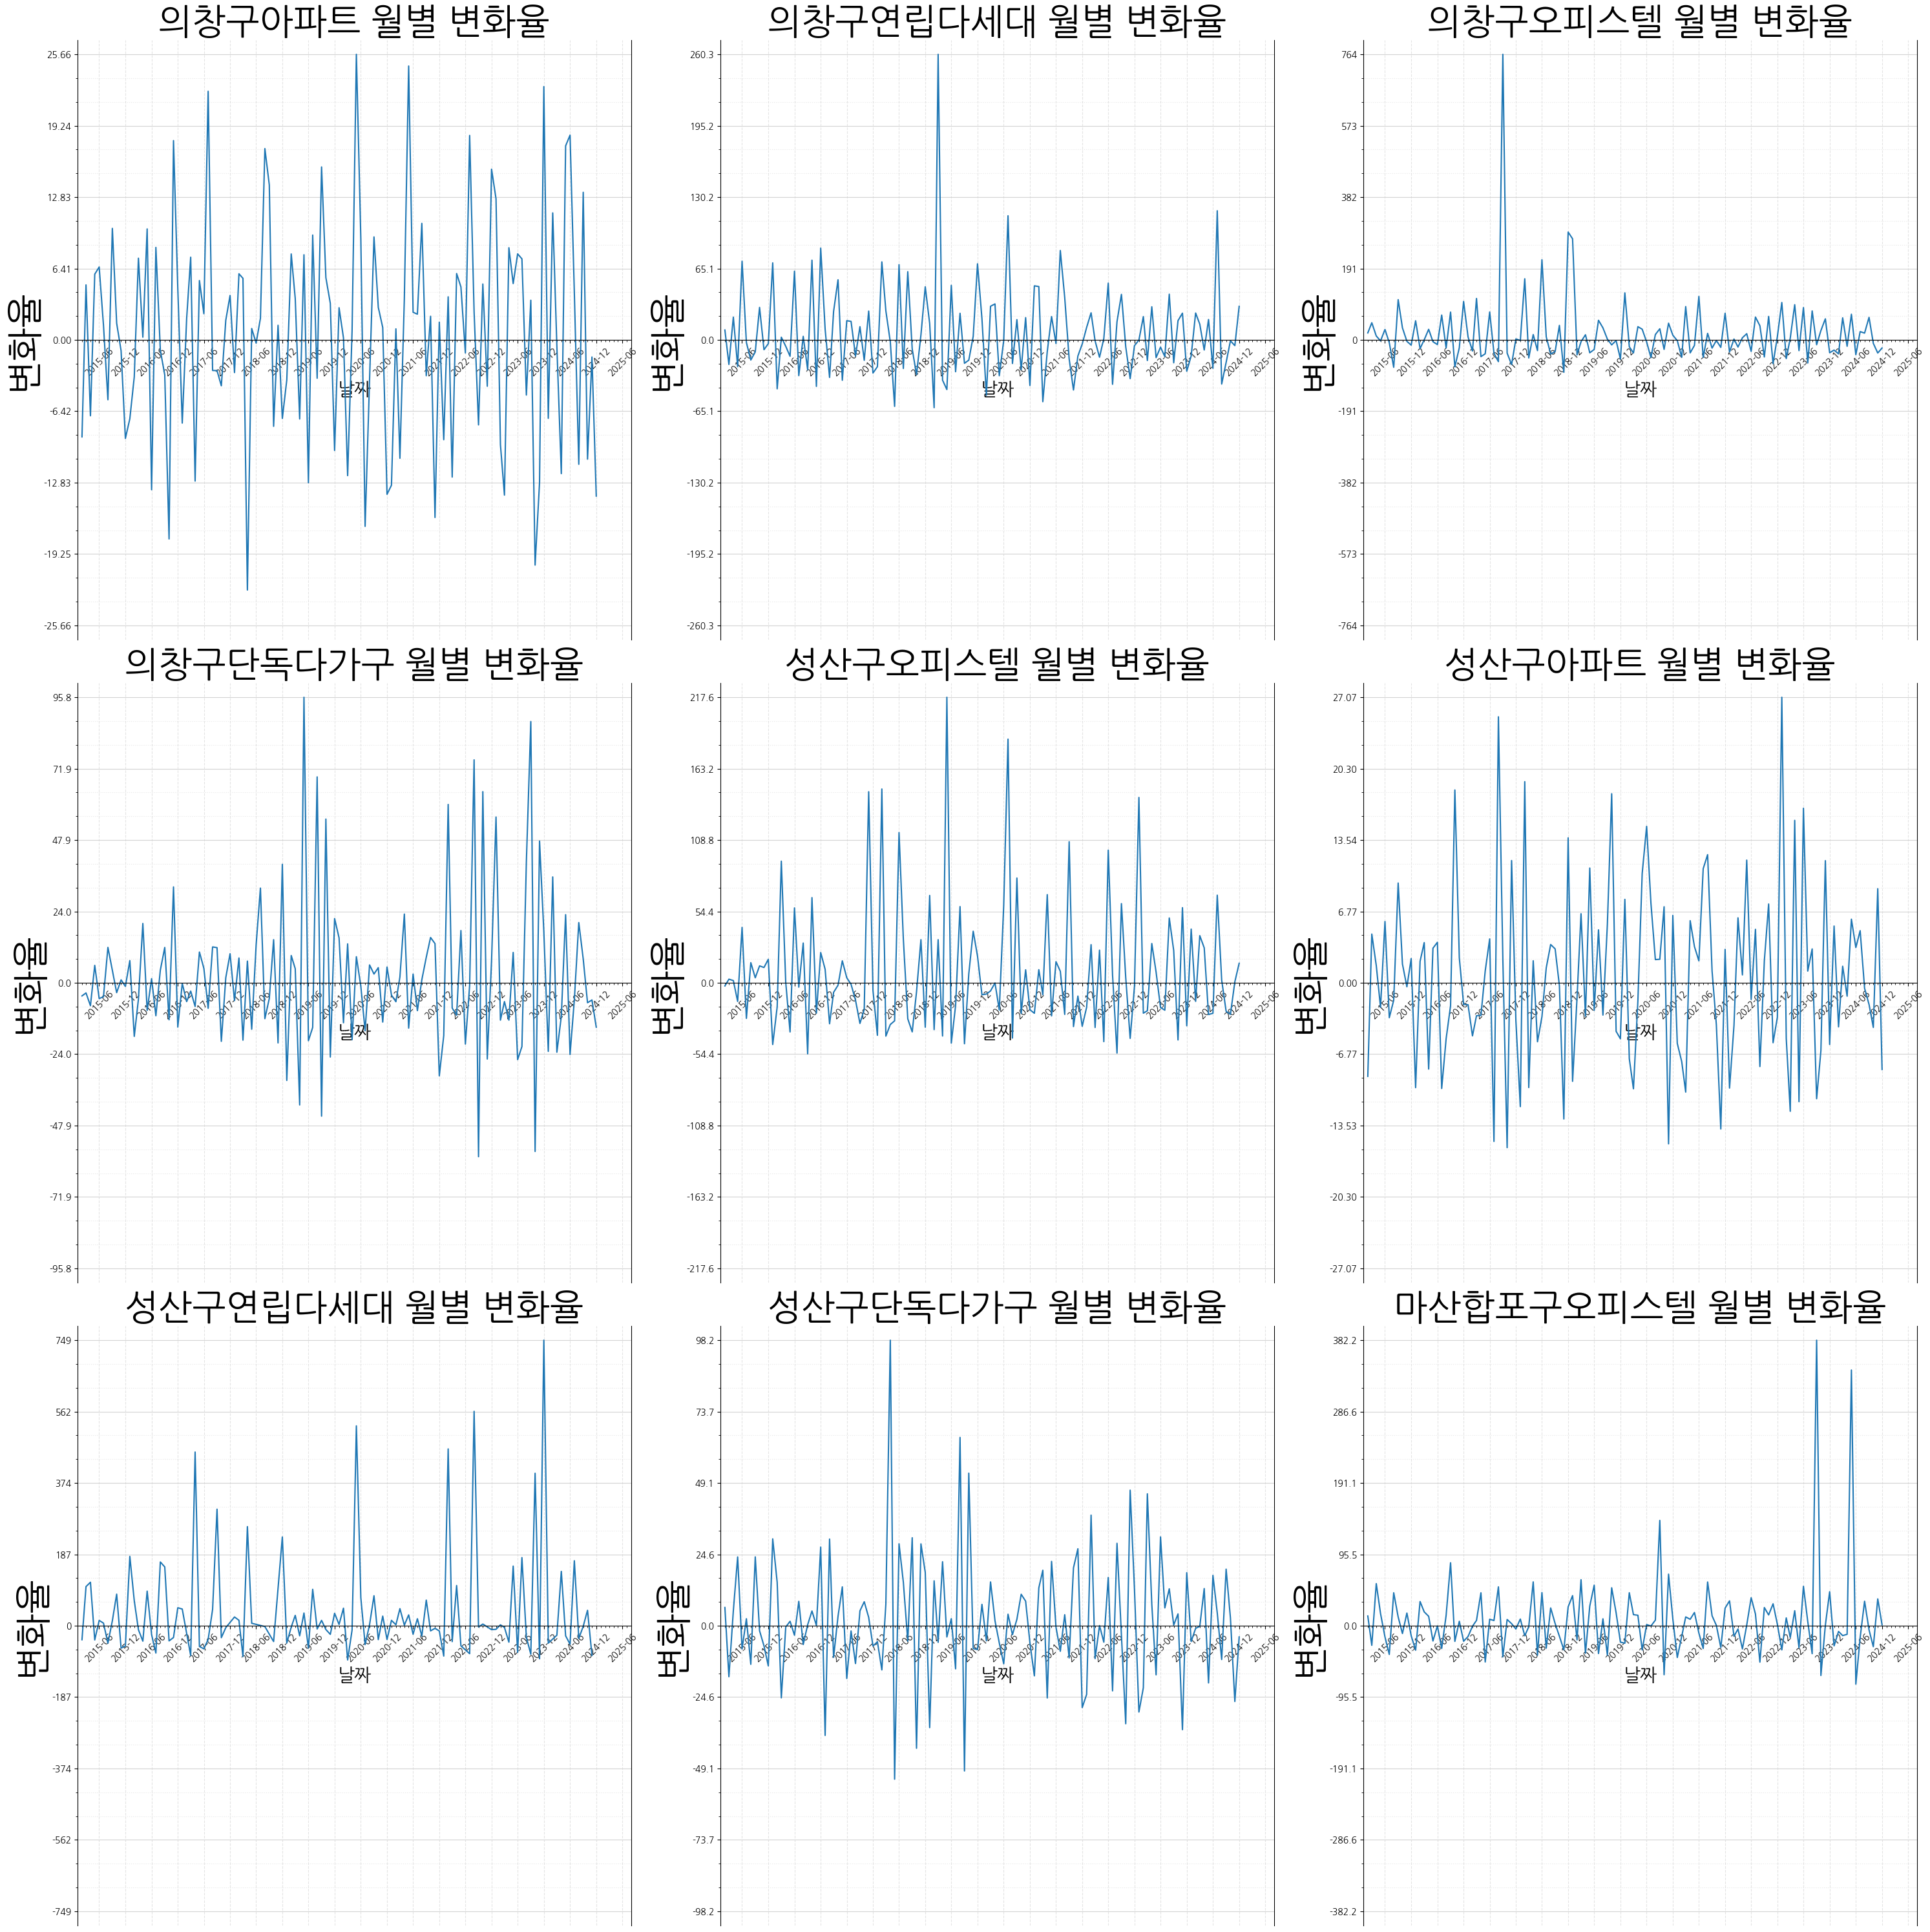

Saved 0.png


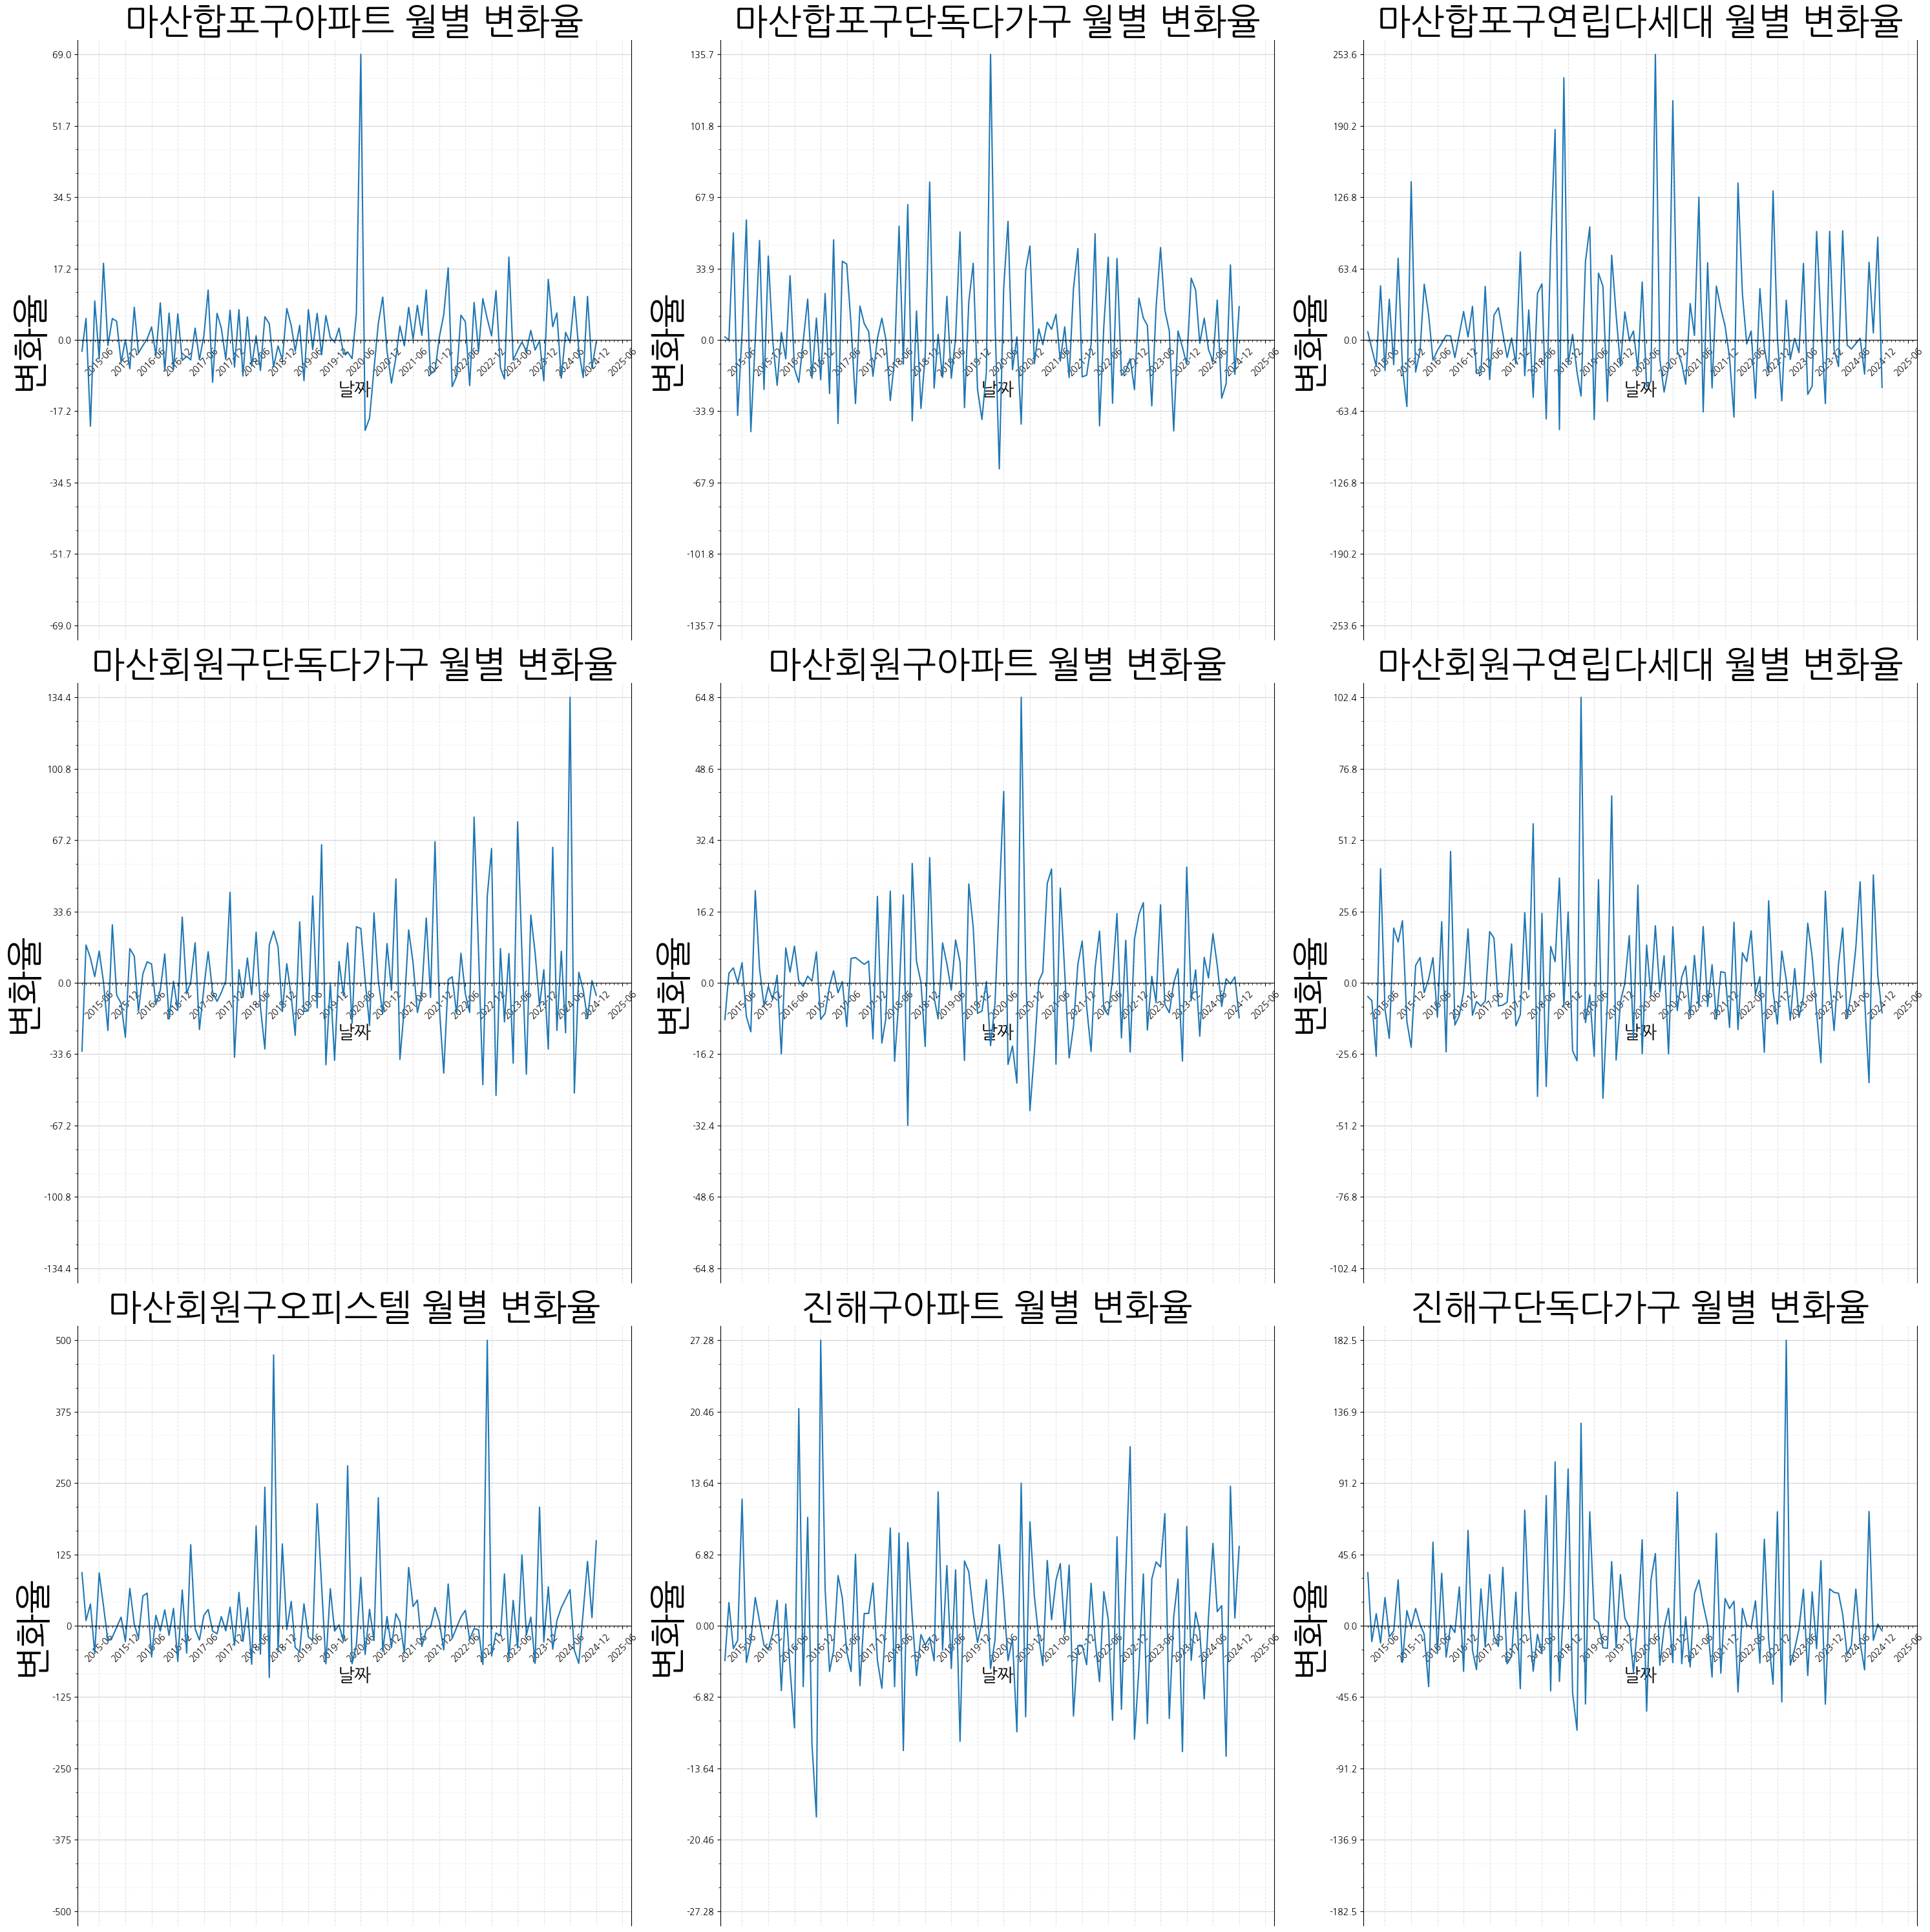

Saved 1.png


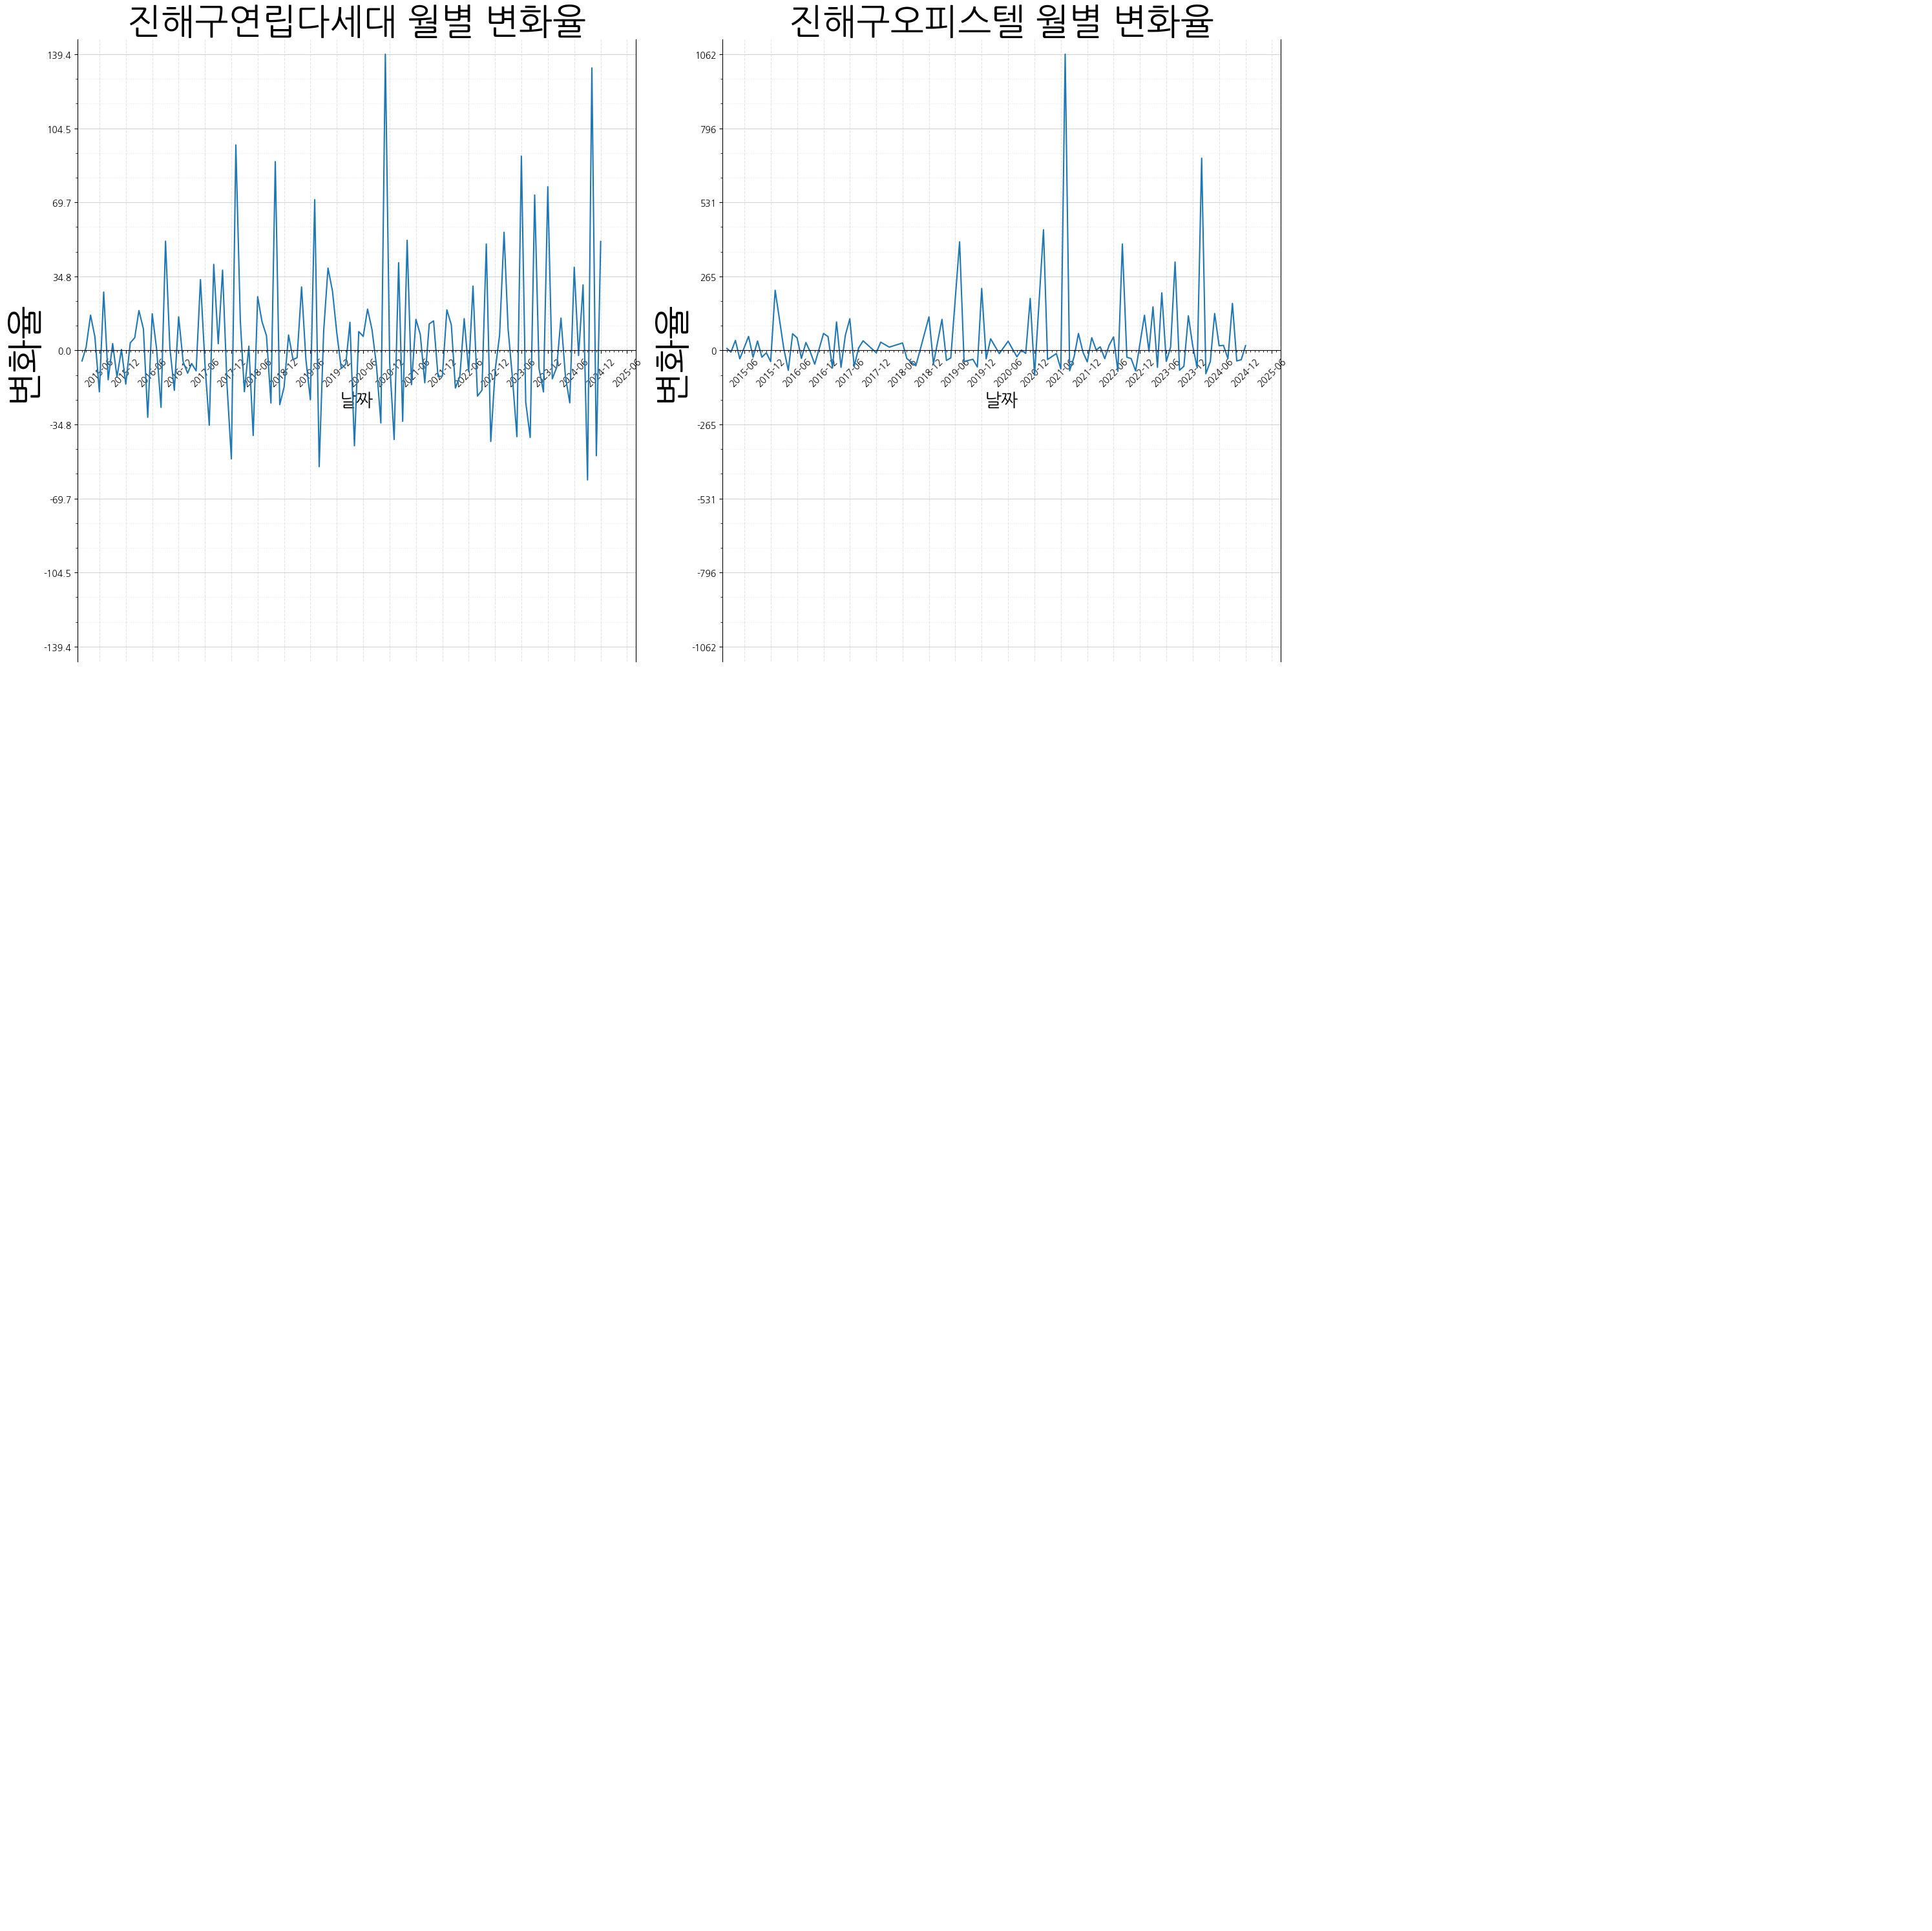

Saved 2.png


In [6]:
# df_list가 데이터프레임의 평탄한 리스트인지, 아니면 리스트-오브-리스트인지 모두 처리하는 코드입니다.
import itertools
x_min_dt = pd.Timestamp('2015-01-01')
x_max_dt = pd.Timestamp('2025-08-01')
TICK_INTERVAL_MONTHS = 6  # 월 단위 동일 간격

def flatten(lst):
    for item in lst:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

def chunked(iterable, n):
    it = iter(iterable)
    while True:
        batch = list(itertools.islice(it, n))
        if not batch:
            break
        yield batch

# # 단일 DataFrame 또는 (중첩) 리스트 모두 지원
# if isinstance(df_avg_list, pd.DataFrame):
#     flattened = [df_avg_list]
# else:
flat_list = list(flatten(df_avg_list))
flattened = [df if isinstance(df, pd.DataFrame) else None for df in flat_list]

ncols = 3
nrows = 3
n_plots_per_page = ncols * nrows
count = 0

for chunk in chunked(flattened, n_plots_per_page):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))
    axes = axes.flatten()

    for idx, df in enumerate(chunk):
        ax = axes[idx]

        if df is None or (hasattr(df, "empty") and df.empty):
            ax.set_axis_off()
            continue

        # plotting column
        plot_col = '변화율' if '변화율' in df.columns else None
        if plot_col is None:
            ax.set_axis_off()
            continue

        series = df[plot_col].dropna()
        if series.empty:
            ax.set_axis_off()
            continue

        max_abs = max(abs(series.min()), abs(series.max()))
        pad = max(0.1, max_abs * 0.05)
        y_min, y_max = -max_abs - pad, max_abs + pad

        df_plot = df.copy()
        df_plot['date'] = pd.to_datetime(df_plot['계약년월'].astype(str), format='%Y%m', errors='coerce')

        sns.lineplot(data=df_plot, x='date', y=plot_col, ax=ax)
        ax.set_title(f"{df['시군구'].values[0]} 월별 변화율", fontsize=40)
        ax.set_xlabel("날짜", fontsize=20)
        ax.set_ylabel("변화율", fontsize=40)
        ax.set_xlim(x_min_dt, x_max_dt)
        ax.set_ylim(y_min, y_max)

        # x축: 월 단위 동일 간격 및 포맷
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=TICK_INTERVAL_MONTHS))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.tick_params(axis='x', labelrotation=45)

        # 0 기준선 맞추기 시도
        try:
            ax.spines['bottom'].set_position(('data', 0))
        except Exception:
            pass

        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

        step = max(1e-6, (max_abs / 4) if max_abs > 0 else 1)
        ax.yaxis.set_major_locator(mticker.MultipleLocator(step))
        ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(3))
        ax.grid(which='major', axis='y', linestyle='-', color='lightgray', linewidth=0.8)
        ax.grid(which='minor', axis='y', linestyle=':', color='lightgray', alpha=0.5)

        # x축 그리드
        ax.grid(which='major', axis='x', linestyle='--', color='lightgray', alpha=0.6)

    # 남는 서브플롯 비활성화 (루프 바깥에서, 변수명 충돌 방지)
    for ax_rest in axes[len(chunk):]:
        ax_rest.set_axis_off()

    plt.tight_layout()
    fig.savefig(f"{count}.png", dpi=300)
    plt.show()
    print(f"Saved {count}.png")
    count += 1